# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
# from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# Using prettyTable for showing the observations
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= ["Vectorizer","Model","Hyperparameters","AUC Score"]
print(table)

+------------+-------+-----------------+-----------+
| Vectorizer | Model | Hyperparameters | AUC Score |
+------------+-------+-----------------+-----------+
+------------+-------+-----------------+-----------+


In [3]:
dir_path = '../'
print(os.listdir(dir_path))

['Assignment1_Habermans', 'models', 'database.sqlite', 'Assignment5_LogisticRegression', 'Assignment4_NaiveBayes', 'CNN', 'Assignment2_AmazonFoodReviews', 'Assignment8_DT', 'Assignment3_kNN', 'Assignment6_SGD', 'Assignment7_SVM', 'Assignment9_RF']


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect(dir_path+'database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 
# 500000 data points you can change the number to any other number 
# based on your computing power

filtered_data = pd.read_sql_query(
            "SELECT * FROM Reviews WHERE Score < 3 LIMIT 55000"
            , con)
filtered_data = filtered_data.append(
            pd.read_sql_query(
            "SELECT * FROM Reviews WHERE Score > 3 LIMIT 55000"
            , con))
 

# Give reviews with Score>3 a positive rating(1), and reviews with a
# score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (110000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
# Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, 
                                      ascending=True, inplace=False,
                                      kind='quicksort', 
                                      na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName",
                                          "Time","Text"}, 
                                  keep='first', inplace=False)
final.shape

(90187, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

81.98818181818181

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(90185, 10)


1    49643
0    40542
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
The tree and pot which arrived were not the ones pictured.  Also, the trunk has several indentions and rust spots from where improper wire was left on the trunk too long.  I expected better.
I did my research before deciding to spend $30+ on a bottle of vanilla, granted a very large one. After reading all the comments, I expected the pleasant aroma of vanilla wafting from the bottle upon opening, but what I got instead was this murky, smokey smell that doesn't even remotely resemble vanilla. There is absolutely no vanilla aroma when I added it to my custards, even with additional amount. Sure, the vanilla specks are there, but what good would they do if they give nothing to the flavor of the dish? I must have gotten a bad bottle or something (is that even po

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
The tree and pot which arrived were not the ones pictured.  Also, the trunk has several indentions and rust spots from where improper wire was left on the trunk too long.  I expected better.
I did my research before deciding to spend $30+ on a bottle of vanilla, granted a very large one. After reading all the comments, I expected the pleasant aroma of vanilla wafting from the bottle upon opening, but what I got instead was this murky, smokey smell that doesn't even remotely resemble vanilla. There is absolutely no vanilla aroma when I added it to my custards, even with additional amount. Sure, the vanilla specks are there, but what good would they do if they give nothing to the flavor of the dish? I must have gotten a bad bottle or something (is that even po

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I did my research before deciding to spend $30+ on a bottle of vanilla, granted a very large one. After reading all the comments, I expected the pleasant aroma of vanilla wafting from the bottle upon opening, but what I got instead was this murky, smokey smell that does not even remotely resemble vanilla. There is absolutely no vanilla aroma when I added it to my custards, even with additional amount. Sure, the vanilla specks are there, but what good would they do if they give nothing to the flavor of the dish? I must have gotten a bad bottle or something (is that even possible, for vanilla bean paste to go bad?). I am quite disappointed, looks like I will just have to stick with Costco vanilla extract from now on.


In [21]:
#remove words with numbers python: 
# https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [22]:
#remove spacial character: 
# https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I did my research before deciding to spend 30 on a bottle of vanilla granted a very large one After reading all the comments I expected the pleasant aroma of vanilla wafting from the bottle upon opening but what I got instead was this murky smokey smell that does not even remotely resemble vanilla There is absolutely no vanilla aroma when I added it to my custards even with additional amount Sure the vanilla specks are there but what good would they do if they give nothing to the flavor of the dish I must have gotten a bad bottle or something is that even possible for vanilla bean paste to go bad I am quite disappointed looks like I will just have to stick with Costco vanilla extract from now on 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', \
                'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', \
                'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', \
                'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', \
                'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', \
                'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because',\
                'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', \
                'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', \
                'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', \
                'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', \
                'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",\
                'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', \
                "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',\
                'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",\
                'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
review_score = []
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() \
                        if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 90185/90185 [00:30<00:00, 2946.60it/s]


In [25]:
preprocessed_reviews[1500]

'research deciding spend bottle vanilla granted large one reading comments expected pleasant aroma vanilla wafting bottle upon opening got instead murky smokey smell not even remotely resemble vanilla absolutely no vanilla aroma added custards even additional amount sure vanilla specks good would give nothing flavor dish must gotten bad bottle something even possible vanilla bean paste go bad quite disappointed looks like stick costco vanilla extract'

In [26]:
len(preprocessed_reviews)

90185

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
preprocessed_summary = []
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary)   # adding 0-9 in the regex
    summary = ' '.join(e.lower() for e in summary.split()\
                       if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 90185/90185 [00:19<00:00, 4610.65it/s]


In [28]:
len(preprocessed_summary)

90185

In [29]:
preprocessed_text = [str(rev+' '+summ) for rev, summ in \
                     zip(preprocessed_reviews, preprocessed_summary)]
print(preprocessed_text[:5])

['one best children books ever written mini version book not portrayed one priced product sent email regarding bewilderment amazon got no response awesome book poor size', 'give five stars maurice sendak story one star printed edition book children older copy book familiar previous softcover version ordered granddaughters embarrassed give gift looks puny book size postcard think overpriced learned lesson not buying softcover children books next time get used copy story great softcover book disappointing', 'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports made china', 'dogs love saw pet store tag attached regarding made china satisfied safe dog lover delites', 'selected company even though price higher hoping pieces would consistent size tuened container filled smaller crum like pieces worse company never buy anything company sbould get crums']


In [30]:
# importing train_test_split to split data
from sklearn.model_selection import train_test_split

In [31]:
# this is random splitting into train, test and cross validation set
ppText_train, ppText_test, rs_train, rs_test = train_test_split(
                            preprocessed_text, review_score,
                            test_size=0.30, random_state = 0,
                            stratify = review_score) 

In [32]:
print("Train data length ", len(ppText_train))
print("Test data length ", len(ppText_test))

Train data length  63129
Test data length  27056


In [33]:
ppText_train[:3]

['best sauce boneless chicken wings also great bone wings closest thing favorite wings great restaurant visit frequently gold fever',
 'sauce taste like italian dressing not good one salty hard find chipotle not like flavor artificial like blend not well made salty',
 'like use energy time time help self get energy not replace poor diet no exercise mind remember eat healthy get exercise sometimes need little something something instead ho hum coffee good option lot better soda definitely picks perks think even better coffee good late afternoon need keep working kind tired gives energy keep going tastes great not sweet keep one stashed purse emergencies received free sample energy energy berry good give zip']

# [4] Featurization

## [4.1] BAG OF WORDS

In [34]:
#BoW
fullPath = dir_path+'models/RF_Trees/'+'bow_vectors.pickle'
useOldData = True
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10,
                          max_features=5000) #in scikit-learn
count_vect.fit(ppText_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        bow_train, bow_test = pickle.load(f)
    
else:
    bow_train = count_vect.transform(ppText_train)
    bow_test = count_vect.transform(ppText_test)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump((bow_train, bow_test), f)

print("\nShapes After Vectorization ")
print("Train shape ", bow_train.shape, len(rs_train))
print("Test shape  ", bow_test.shape, len(rs_test))
print("Unique words in training : ", bow_train.get_shape()[1])

some feature names  ['able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves', 'absolutely no', 'absorb']
Reading vectors from drive..

Shapes After Vectorization 
Train shape  (63129, 5000) 63129
Test shape   (27056, 5000) 27056
Unique words in training :  5000


## [4.2] Bi-Grams and n-Grams.

In [35]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation 
#http://scikit-learn.org/stable/modules/generated/
#sklearn.feature_extraction.text.CountVectorizer.html

count_vect_bi = CountVectorizer(ngram_range=(1,2), min_df=10, 
                                max_features=5000)
final_bigram_counts = count_vect_bi.fit_transform(preprocessed_text)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", 
                    final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (90185, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [36]:
fullPath = dir_path+'models/RF_Trees/'+'tfIdf_vectors.pickle'
useOldData=True
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,
                             max_features=5000)
tf_idf_vect.fit(ppText_train)
print("Some sample features(unique words in the training corpus)",
    tf_idf_vect.get_feature_names()[0:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        tfIdf_train, tfIdf_test = pickle.load(f)
    
else:
    tfIdf_train = tf_idf_vect.transform(ppText_train)
    tfIdf_test = tf_idf_vect.transform(ppText_test)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump((tfIdf_train, tfIdf_test), f)


print("\nShapes After Vectorization ")
print("Train shape ", tfIdf_train.shape, len(rs_train))
print("Test shape  ", tfIdf_test.shape, len(rs_test))
print("Unique words in training : ", tfIdf_train.get_shape()[1])

Some sample features(unique words in the training corpus) ['able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves', 'absolutely no', 'absorb']
Reading vectors from drive..

Shapes After Vectorization 
Train shape  (63129, 5000) 63129
Test shape   (27056, 5000) 27056
Unique words in training :  5000


## [4.4] Word2Vec

In [37]:
# Train your own Word2Vec model using your own text corpus
i=0

# list of sentences divided into train and test set
train_sentences = [sentence.split() for sentence in ppText_train]
test_sentences = [sentence.split() for sentence in ppText_test]

In [38]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need


is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True
fullPath = dir_path+'models/RF_Trees/'+'w2V_model.pickle'
useOldData=True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    if os.path.isfile(fullPath) and useOldData:
        with open(fullPath, 'rb') as f:
            w2v_model = pickle.load(f)
    else:
        w2v_model=Word2Vec(train_sentences,min_count=5,size=128, workers=4)
        # Save word2Vec model
        with open(fullPath,'wb') as f:
            pickle.dump(w2v_model, f)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format(
                      'GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep \
          want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.7782045006752014), ('excellent', 0.7723748683929443), ('fantastic', 0.7669318914413452), ('awesome', 0.755804717540741), ('wonderful', 0.7182766199111938), ('good', 0.6978761553764343), ('fabulous', 0.6485247611999512), ('perfect', 0.6470597982406616), ('amazing', 0.6342414617538452), ('outstanding', 0.597248911857605)]
[('nastiest', 0.7938729524612427), ('weakest', 0.7107030153274536), ('greatest', 0.66075599193573), ('best', 0.6474962830543518), ('disgusting', 0.6382350921630859), ('grossest', 0.6238590478897095), ('misfortune', 0.6078242063522339), ('worse', 0.5941334962844849), ('smoothest', 0.5912959575653076), ('terrible', 0.5911763906478882)]


In [39]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16053
sample words  ['best', 'sauce', 'boneless', 'chicken', 'wings', 'also', 'great', 'bone', 'closest', 'thing', 'favorite', 'restaurant', 'visit', 'frequently', 'gold', 'fever', 'taste', 'like', 'italian', 'dressing', 'not', 'good', 'one', 'salty', 'hard', 'find', 'chipotle', 'flavor', 'artificial', 'blend', 'well', 'made', 'use', 'energy', 'time', 'help', 'self', 'get', 'replace', 'poor', 'diet', 'no', 'exercise', 'mind', 'remember', 'eat', 'healthy', 'sometimes', 'need', 'little']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [40]:
fullPath = dir_path+'models/RF_Trees/'+'avg_W2V.pickle'
useOldData=True

# average Word2Vec

avgW2V_train, avgW2V_test = None, None
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        avgW2V_train, avgW2V_test = pickle.load(f)
    
else:
    for i, sent_set in enumerate([train_sentences, test_sentences]):
        for sent in sent_set:
            c += 1
            if c % 1000==0:
                print("Progress : {:3d} %  ".format(
                        int(c/len(preprocessed_reviews)*100)),
                        end='\r')
            sent_vec = np.zeros(128)
            cnt_words = 0
            for word in sent:
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    sent_vec += vec
                    cnt_words += 1
            if cnt_words != 0:
                sent_vec /= cnt_words
            if i==0:
                avgW2V_train.append(sent_vec)
            if i==1:
                avgW2V_test.append(sent_vec)
  
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump((avgW2V_train, avgW2V_test), f)

print("Dims of Train : ({}, {})".format(len(avgW2V_train), 
                                        len(avgW2V_train[0])))
print("Dims of Test : ({}, {})".format(len(avgW2V_test), 
                                       len(avgW2V_test[0])))

Vectors loaded from drive..
Dims of Train : (63129, 128)
Dims of Test : (27056, 128)


#### [4.4.1.2] TFIDF weighted W2v

In [41]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=5)
tf_idf_matrix = model.fit_transform(ppText_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, 
# col=word and cell_val = tfidf

fullPath = dir_path+'models/RF_Trees/'+'tfIdf_avg_W2V.pickle'
useOldData=True

tfidf_avgW2V_train, tfidf_avgW2V_test = None, None
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        tfidf_avgW2V_train, tfidf_avgW2V_test = pickle.load(f)
    
else:
    for i, sent_set in enumerate([train_sentences, test_sentences]):
        for sent in sent_set:
            c += 1
            if c % 1000==0:
                print("Progress : {:3d} %  ".format(
                        int(c/len(preprocessed_reviews)*100)), 
                        end='\r')
            sent_vec = np.zeros(128)
            weight_sum = 0
            for word in sent:
                if word in w2v_words and word in tfidf_feat:
                    vec = w2v_model.wv[word]
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
            if weight_sum != 0:
                sent_vec /= weight_sum
            if i==0:
                tfidf_avgW2V_train.append(sent_vec)
            if i==1:
                tfidf_avgW2V_test.append(sent_vec)
              
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump((tfidf_avgW2V_train, tfidf_avgW2V_test), f)
    

print("Dims of Train : ({}, {})".format(len(tfidf_avgW2V_train), 
                                        len(tfidf_avgW2V_train[0])))
print("Dims of Test : ({}, {})".format(len(tfidf_avgW2V_test), 
                                       len(tfidf_avgW2V_test[0])))

Vectors loaded from drive..
Dims of Train : (63129, 128)
Dims of Test : (27056, 128)


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, roc_curve, auc \
                , accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from IPython.display import Image  
import pydotplus
from wordcloud import WordCloud

In [44]:
def RF_Classifier(X_train, y_train):
    max_depth = np.array([5, 15, 30, 50, 75, 100, 125, 150])
    min_samples_leaf = np.array([1, 3, 5, 10, 20, 50])
    n_estimators = np.array([50, 150, 300, 500])
#     max_depth = np.array([5])
#     min_samples_leaf = np.array([1, 3, 5])
#     n_estimators = np.array([5, 10])
    params_dict = [{'max_depth': max_depth,'min_samples_leaf': min_samples_leaf,
                    'n_estimators': n_estimators}]
    rf_optimal = RandomForestClassifier(random_state=1,n_jobs=6,
                                        class_weight='balanced')
    
    grid = GridSearchCV(estimator=rf_optimal, 
                        param_grid=params_dict, 
                        scoring='roc_auc', n_jobs=4, cv=5,
                        return_train_score=True)
    
    grid_result = grid.fit(X_train, y_train)
    train_auc = grid_result.cv_results_['mean_train_score']
    train_auc_std = grid_result.cv_results_['std_train_score']
    cv_auc = grid_result.cv_results_['mean_test_score']
    cv_auc_std = grid_result.cv_results_['std_test_score']
    
    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
#     print(train_auc)
#     print(grid_result.cv_results_)
#     print("Previous : ", train_auc.shape)
    train_auc = train_auc.reshape(len(max_depth),len(min_samples_leaf),len(n_estimators))
    cv_auc = cv_auc.reshape(len(max_depth),len(min_samples_leaf),len(n_estimators))
    
    for msl in range(len(min_samples_leaf)): 
        plt.figure(figsize=(10.0, 8.0))
        ax = sns.heatmap(train_auc[:,msl,:], 
                     annot=True, square=False,  cmap="Oranges",
                     xticklabels=["nE = "+str(ne) for ne in n_estimators],
                     yticklabels=["mD = "+str(md) for md in max_depth])

        plt.title("Training scores for max_depth and num_estimators "+
                  "with min_sample_leaf="+str(min_samples_leaf[msl]))
        plt.show()
        print('')

        plt.figure(figsize=(10.0, 8.0))
        ax = sns.heatmap(cv_auc[:,msl,:], 
                     annot=True, square=False,  cmap="Blues",
                     xticklabels=["nE = "+str(ne) for ne in n_estimators],
                     yticklabels=["md = "+str(md) for md in max_depth])
        plt.title("Cross-val scores for max_depth and num_estimators "+
                 "with min_sample_leaf="+str(min_samples_leaf[msl]))
        plt.show()

In [45]:
def RF_Classifier_Test(n_estimators, maxDepth, min_samples_leaf,
                       X_train, y_train, X_test, y_test):
    # Setting up the classifier using optimal params

    rf_optimal = RandomForestClassifier(max_depth=maxDepth,
                                        min_samples_leaf=min_samples_leaf,
                                        n_estimators=n_estimators,
                                        n_jobs=4,class_weight='balanced',
                                        random_state=1)
    
    # we have to fit the SGDClassifier so that we can access the coef_
    rf_optimal.fit(X_train, y_train)
    
    # Prediction on training and test set using optimal classifier
    logProb_train = rf_optimal.predict_proba(X_train)
    logProb_test = rf_optimal.predict_proba(X_test)
    pred_train = np.argmax(logProb_train, axis =1)
    pred_test = np.argmax(logProb_test, axis =1)
    print("Using max depth value for tree - ", maxDepth)
    print("Using num estimators for tree - ", n_estimators)
    print("Train accuracy for optimal Decision Tree ", round(
                        accuracy_score(y_train, pred_train)*100, 2))
    print("Test accuracy for optimal Decision Tree ", round(
                        accuracy_score(y_test, pred_test) * 100, 2))

    # ROC-AUC on train & test data
    train_fpr, train_tpr, thresholds = roc_curve(y_train, 
                                logProb_train[:, 1], pos_label=1)
    test_fpr, test_tpr, thresholds = roc_curve(y_test, 
                                logProb_test[:, 1], pos_label=1)


    # Draw ROC curve
    plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(
                                    auc(train_fpr, train_tpr), 2)))
    auc_score = round(auc(test_fpr, test_tpr), 2)
    plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
    plt.legend()
    plt.xlabel("False Pos Rate")
    plt.ylabel("True Pos Rate")
    plt.title("ROC Curve of Train and Test")
    plt.show()
    
    return rf_optimal, pred_train, pred_test, auc_score

In [46]:
def draw_Confusion_Matrix(actual, predicted):
    class_label = ["negative", "positive"]
    conf_matrix = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
    hm = sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

Optimal Parameters :  {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 125, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


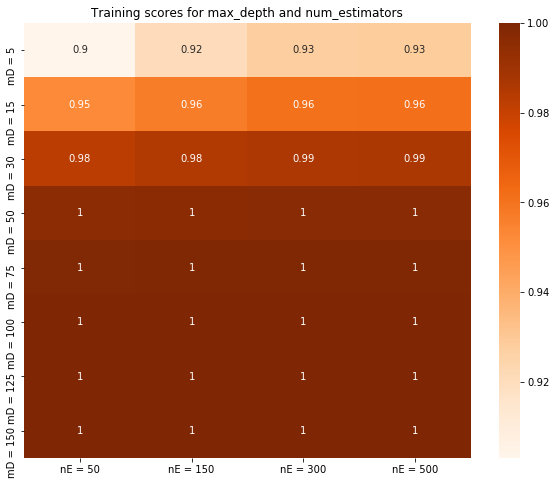

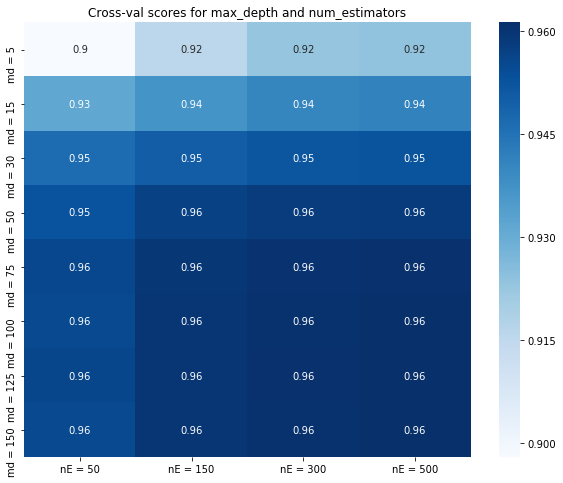

In [43]:
# Please write all the code with proper documentation
RF_Classifier(bow_train, rs_train)

Using max depth value for tree -  125
Using num estimators for tree -  500
Train accuracy for optimal Decision Tree  92.8
Test accuracy for optimal Decision Tree  88.82


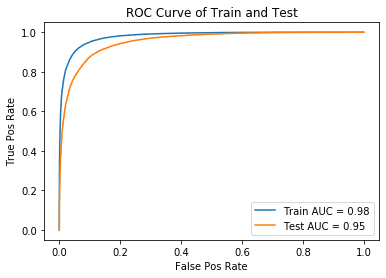

In [47]:
# Please write all the code with proper documentation
maxDepth, n_estimators, min_sample_leaf = 125,500,5
classifier, pred_train, pred_test, auc_score = RF_Classifier_Test(
            n_estimators, maxDepth, min_sample_leaf,
            bow_train, rs_train, bow_test, rs_test)

Training Confusion Matrix


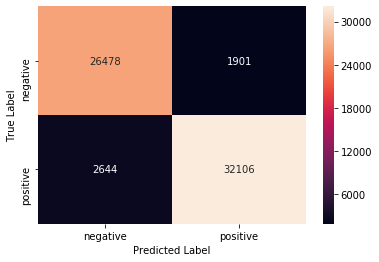




Test Confusion Matrix


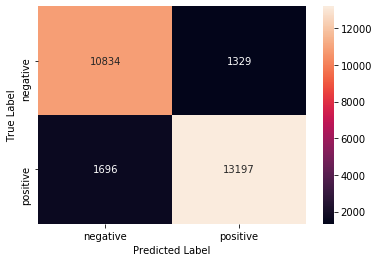

In [48]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["bow", "Random Forest", 
               "maxDepth: {0}  num estimators: {1}".format(
                   maxDepth, n_estimators), auc_score])

In [49]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88     12163
           1       0.91      0.89      0.90     14893

   micro avg       0.89      0.89      0.89     27056
   macro avg       0.89      0.89      0.89     27056
weighted avg       0.89      0.89      0.89     27056



### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [42]:
# Please write all the code with proper documentation
# Top 20 important features
print("Top 20 important features are : ")
print(np.take(count_vect.get_feature_names(), 
    classifier.feature_importances_.argsort()[:-21:-1]))

Top 20 important features are : 
['great' 'not' 'best' 'love' 'delicious' 'disappointed' 'perfect' 'good'
 'excellent' 'not buy' 'bad' 'loves' 'favorite' 'not good' 'awful' 'money'
 'worst' 'easy' 'horrible' 'terrible']


In [43]:
indexes = classifier.feature_importances_.argsort()[:-21:-1]
feature_names = np.take(count_vect.get_feature_names(), indexes)
scores = classifier.feature_importances_[indexes].tolist()
features = dict(zip(feature_names, scores))

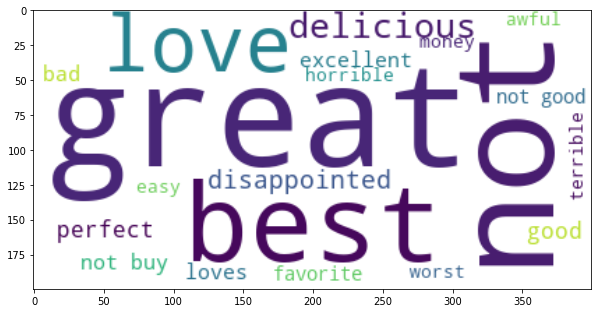

In [57]:
wc = WordCloud(background_color="white",
              min_font_size=10).generate_from_frequencies(features)
plt.figure(figsize=(10.0, 8.0))
plt.imshow(wc, interpolation='bilinear')

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

Optimal Parameters :  {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 150, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


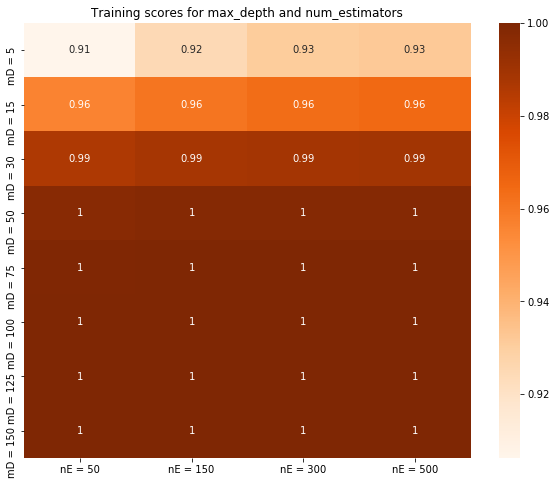

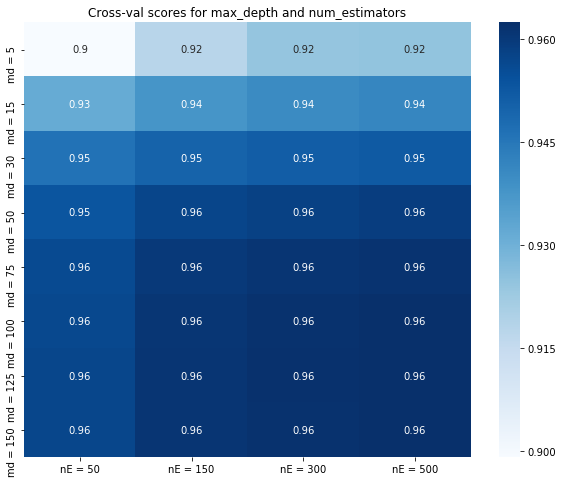

In [56]:
# Please write all the code with proper documentation
RF_Classifier(tfIdf_train, rs_train)

Using max depth value for tree -  150
Using num estimators for tree -  500
Train accuracy for optimal Decision Tree  94.64
Test accuracy for optimal Decision Tree  88.95


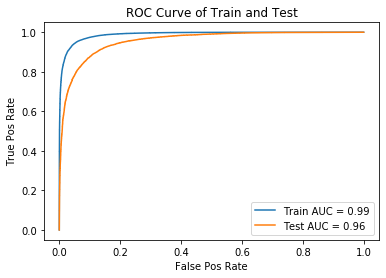

In [50]:
# Please write all the code with proper documentation
maxDepth, n_estimators, min_sample_leaf = 150,500,5
classifier, pred_train, pred_test, auc_score = RF_Classifier_Test(
                        n_estimators, maxDepth, min_sample_leaf,
                        tfIdf_train, rs_train, tfIdf_test, rs_test)

Training Confusion Matrix


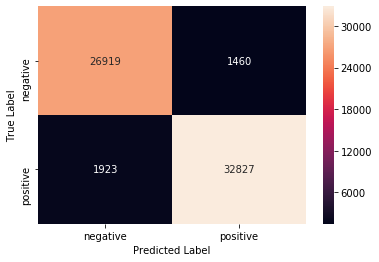




Test Confusion Matrix


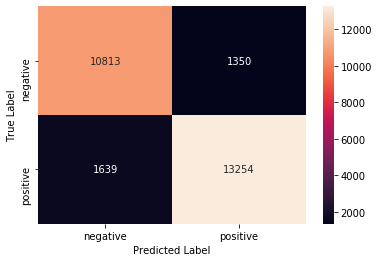

In [51]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["tf-Idf", "Random Forest", 
               "maxDepth: {0}  num estimators: {1}".format(
                   maxDepth, n_estimators), auc_score])

In [52]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     12163
           1       0.91      0.89      0.90     14893

   micro avg       0.89      0.89      0.89     27056
   macro avg       0.89      0.89      0.89     27056
weighted avg       0.89      0.89      0.89     27056



### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [59]:
# Please write all the code with proper documentation
# Top 20 important features
print("Top 20 important features are : ")
print(np.take(tf_idf_vect.get_feature_names(), 
    classifier.feature_importances_.argsort()[:-21:-1]))

Top 20 important features are : 
['great' 'not' 'best' 'love' 'delicious' 'good' 'disappointed' 'perfect'
 'bad' 'loves' 'not buy' 'excellent' 'favorite' 'not good' 'awful' 'easy'
 'money' 'worst' 'horrible' 'terrible']


In [60]:
indexes = classifier.feature_importances_.argsort()[:-21:-1]
feature_names = np.take(tf_idf_vect.get_feature_names(), indexes)
scores = classifier.feature_importances_[indexes].tolist()
features = dict(zip(feature_names, scores))

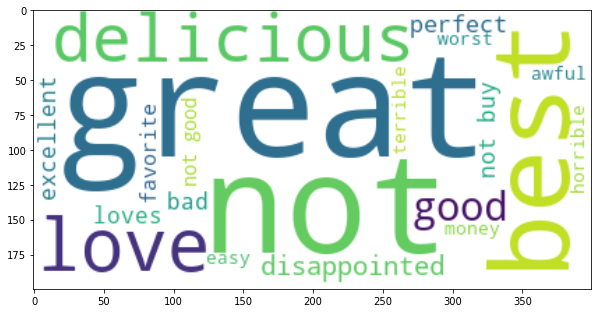

In [62]:
wc = WordCloud(background_color="white",
              min_font_size=10).generate_from_frequencies(features)
plt.figure(figsize=(10.0, 8.0))
plt.imshow(wc, interpolation='bilinear')

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

Optimal Parameters :  {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


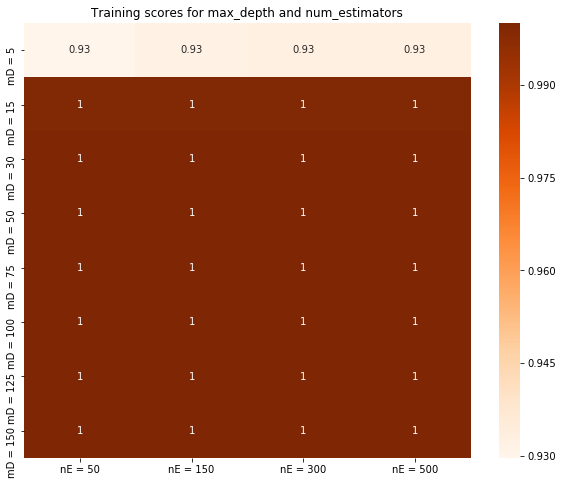

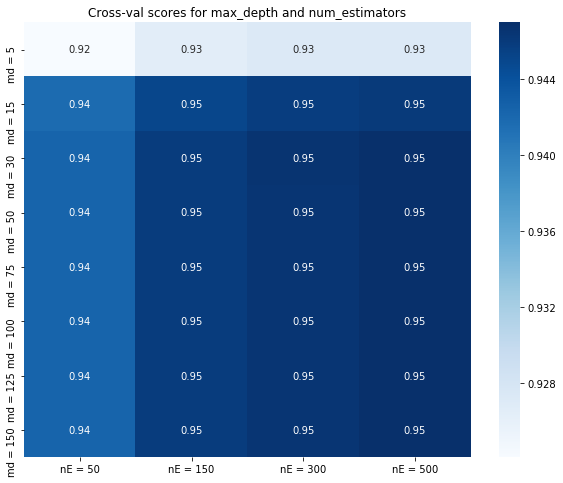

In [42]:
# Please write all the code with proper documentation
RF_Classifier(avgW2V_train, rs_train)

Using max depth value for tree -  3
Using num estimators for tree -  500
Train accuracy for optimal Decision Tree  84.12
Test accuracy for optimal Decision Tree  83.78


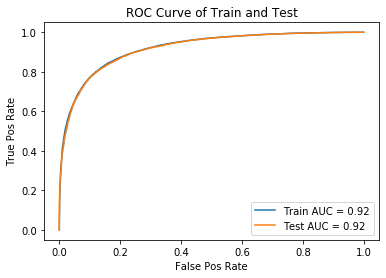

In [57]:
# Please write all the code with proper documentation
maxDepth, min_samples_leaf, n_estimators = 30,3,500
classifier, pred_train, pred_test, auc_score = RF_Classifier_Test(
            n_estimators, min_samples_leaf, maxDepth, avgW2V_train,
            rs_train, avgW2V_test, rs_test)

Training Confusion Matrix


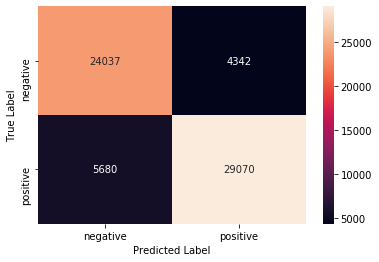




Test Confusion Matrix


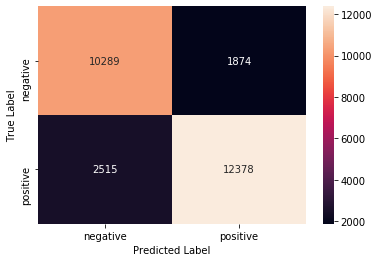

In [58]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Avg W2V", "Random Forest", 
               "maxDepth: {0}  num estimators: {1}".format(
                   maxDepth, n_estimators), auc_score])

In [59]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82     12163
           1       0.87      0.83      0.85     14893

   micro avg       0.84      0.84      0.84     27056
   macro avg       0.84      0.84      0.84     27056
weighted avg       0.84      0.84      0.84     27056



### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

Optimal Parameters :  {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 6, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


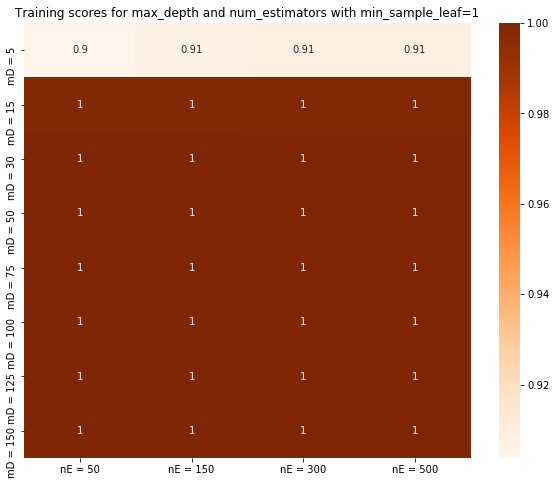

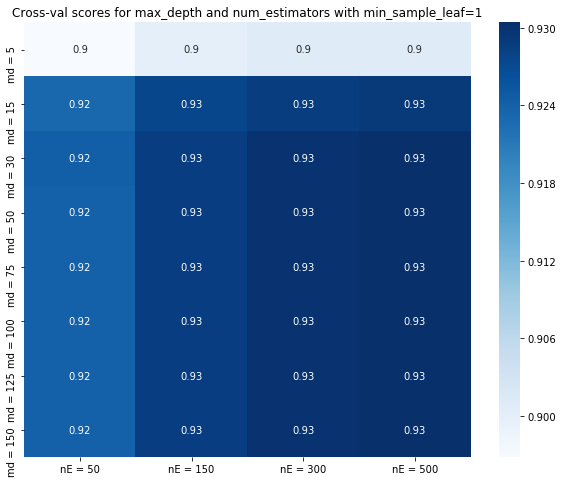

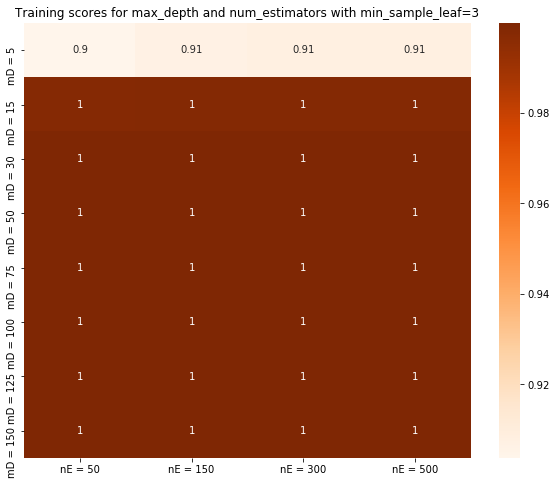

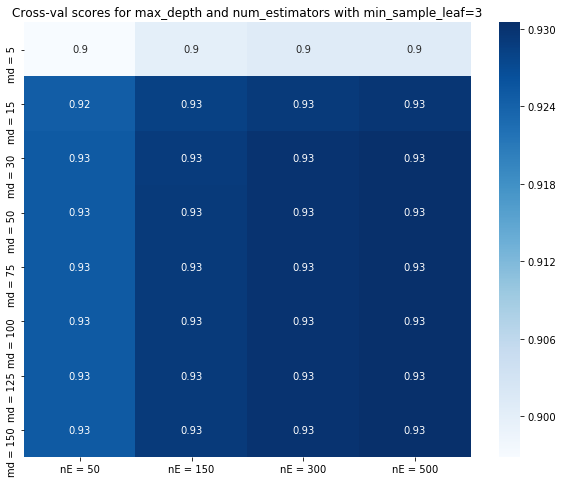

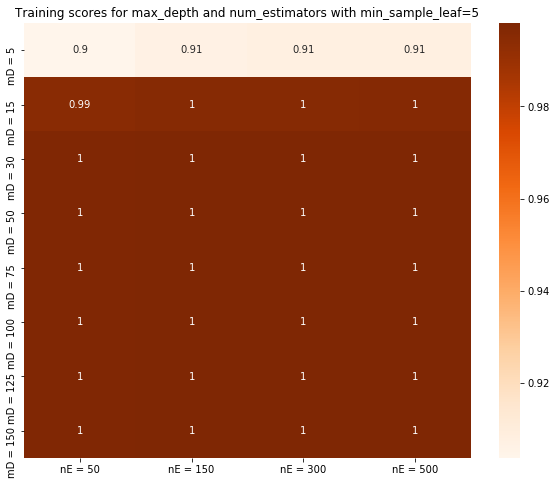

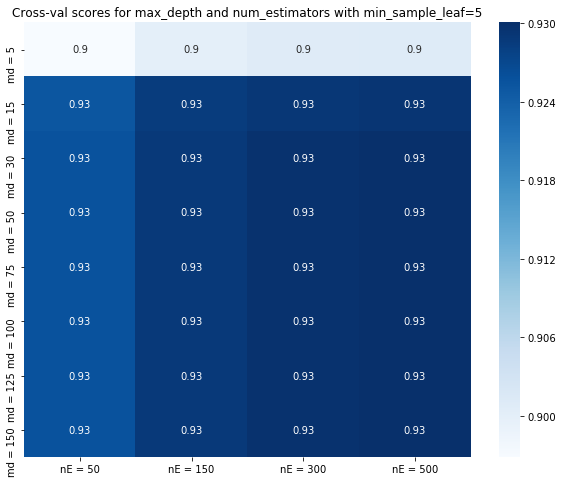

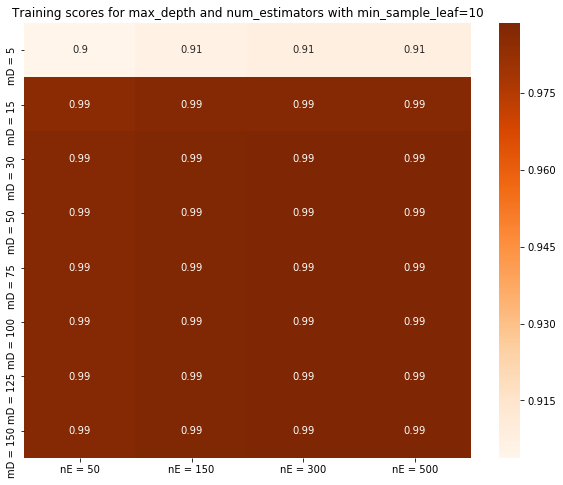

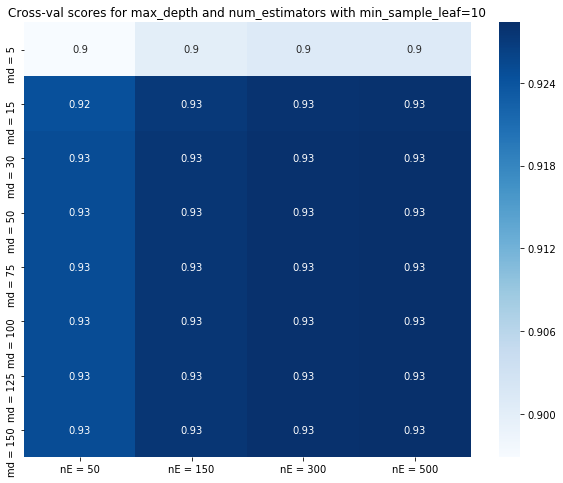

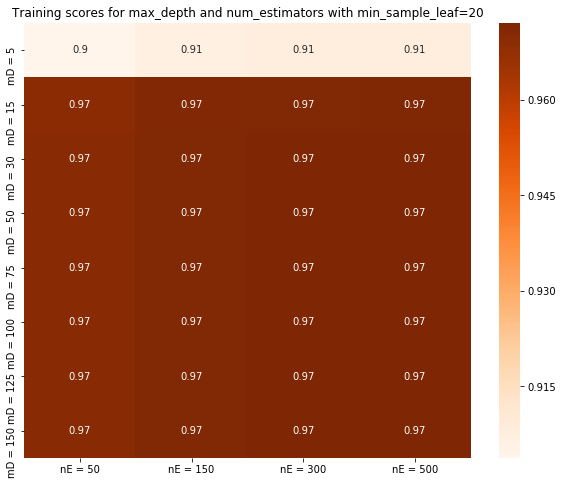

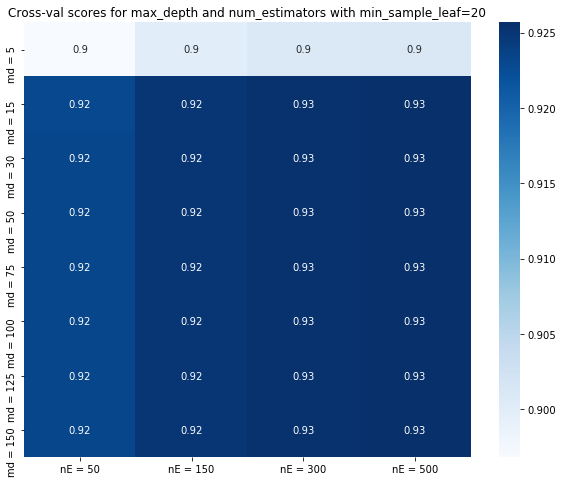

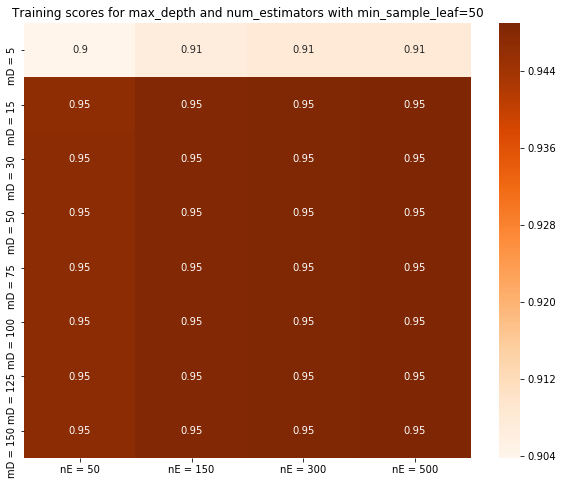

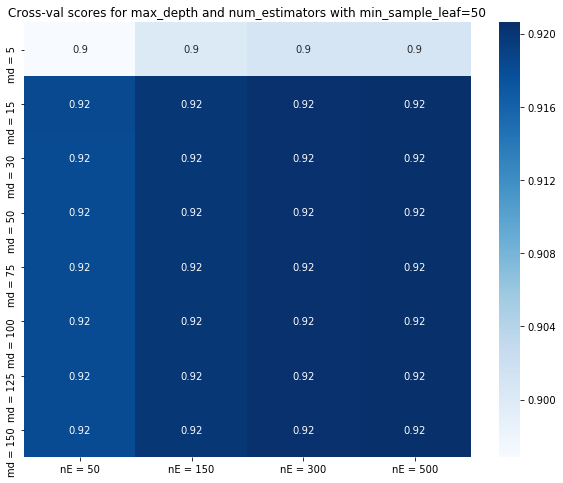

In [101]:
# Please write all the code with proper documentation

# Since all the above vectors looked much like overfitting, so for the
# last tf-Idf weighted average vector, we modified the function a bit 
# to include min_sample_leaf as a hyperparameter too and tweaked the 
# functions defined above a bit

RF_Classifier(tfidf_avgW2V_train, rs_train)

Using max depth value for tree -  3
Using num estimators for tree -  500
Train accuracy for optimal Decision Tree  81.15
Test accuracy for optimal Decision Tree  80.85


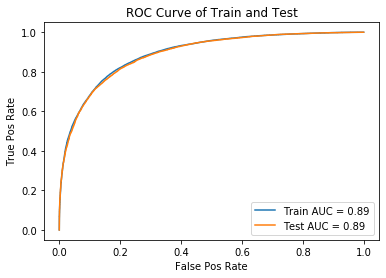

In [61]:
# Please write all the code with proper documentation
maxDepth, min_samples_leaf, n_estimators = 50,3,500
classifier, pred_train, pred_test, auc_score = RF_Classifier_Test(
            n_estimators, min_samples_leaf, maxDepth, tfidf_avgW2V_train, 
            rs_train, tfidf_avgW2V_test, rs_test)

# Although we lost a bit of accuracy (around 5%) but the model is much
# more generalised than the previous try

Training Confusion Matrix


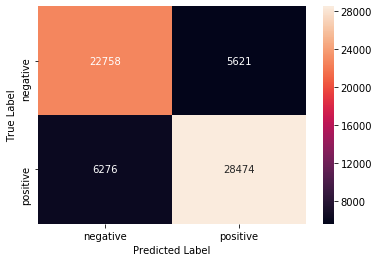




Test Confusion Matrix


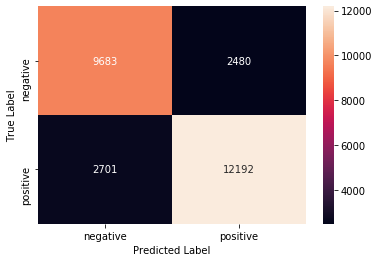

In [62]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf Avg W2V", "Random Forest", 
               "maxDepth: {0} \n num estimators: {1}\n\
min_samples_leaf: {2}".format(
            maxDepth, n_estimators, min_samples_leaf), auc_score])

In [63]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     12163
           1       0.83      0.82      0.82     14893

   micro avg       0.81      0.81      0.81     27056
   macro avg       0.81      0.81      0.81     27056
weighted avg       0.81      0.81      0.81     27056



## [5.2] Applying GBDT using XGBOOST

In [64]:
from xgboost import XGBClassifier

In [65]:
def GBDT_Classifier(X_train, y_train):
    max_depth = np.array([3, 6, 9, 12, 15])
    learning_rate = np.array([0.01, 0.05, 0.1])
    n_estimators = np.array([20, 35, 50, 70, 100])
    params_dict = [{'max_depth': max_depth,'learning_rate': learning_rate,
                    'n_estimators': n_estimators}]
    xgb_optimal = XGBClassifier(random_state=1,n_jobs=6,
                                        class_weight='balanced')
    
    grid = GridSearchCV(estimator=xgb_optimal, 
                        param_grid=params_dict, 
                        scoring='roc_auc', n_jobs=6, cv=5,
                        return_train_score=True)
    
    grid_result = grid.fit(X_train, y_train)
    train_auc = grid_result.cv_results_['mean_train_score']
    train_auc_std = grid_result.cv_results_['std_train_score']
    cv_auc = grid_result.cv_results_['mean_test_score']
    cv_auc_std = grid_result.cv_results_['std_test_score']
    
    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
#     print(train_auc)
#     print(grid_result.cv_results_)
#     print("Previous : ", train_auc.shape)
    train_auc = train_auc.reshape(len(max_depth),len(learning_rate),len(n_estimators))
    cv_auc = cv_auc.reshape(len(max_depth),len(learning_rate),len(n_estimators))
    
    for lr in range(len(learning_rate)): 
        plt.figure(figsize=(10.0, 8.0))
        ax = sns.heatmap(train_auc[:,lr,:], 
                     annot=True, square=False,  cmap="Oranges",
                     xticklabels=["nE = "+str(ne) for ne in n_estimators],
                     yticklabels=["mD = "+str(md) for md in max_depth])

        plt.title("Training scores for max_depth and num_estimators "+
                  "with learning_rate="+str(learning_rate[lr]))
        plt.show()
        print('')

        plt.figure(figsize=(10.0, 8.0))
        ax = sns.heatmap(cv_auc[:,lr,:], 
                     annot=True, square=False,  cmap="Blues",
                     xticklabels=["nE = "+str(ne) for ne in n_estimators],
                     yticklabels=["md = "+str(md) for md in max_depth])
        plt.title("Cross-val scores for max_depth and num_estimators "+
                 "with learning_rate="+str(learning_rate[lr]))
        plt.show()

In [66]:
def GBDT_Classifier_Test(n_estimators, maxDepth, learning_rate,
                       X_train, y_train, X_test, y_test):
    # Setting up the classifier using optimal params

    xgb_optimal = XGBClassifier(max_depth=maxDepth,
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                n_jobs=6,class_weight='balanced',
                                random_state=1)
    
    # we have to fit the SGDClassifier so that we can access the coef_
    xgb_optimal.fit(X_train, y_train)
    
    # Prediction on training and test set using optimal classifier
    logProb_train = xgb_optimal.predict_proba(X_train)
    logProb_test = xgb_optimal.predict_proba(X_test)
    pred_train = np.argmax(logProb_train, axis =1)
    pred_test = np.argmax(logProb_test, axis =1)
    print("Using max depth value for tree - ", maxDepth)
    print("Using num estimators for tree - ", n_estimators)
    print("Train accuracy for optimal GB Tree ", round(
                        accuracy_score(y_train, pred_train)*100, 2))
    print("Test accuracy for optimal GB Tree ", round(
                        accuracy_score(y_test, pred_test) * 100, 2))

    # ROC-AUC on train & test data
    train_fpr, train_tpr, thresholds = roc_curve(y_train, 
                                logProb_train[:, 1], pos_label=1)
    test_fpr, test_tpr, thresholds = roc_curve(y_test, 
                                logProb_test[:, 1], pos_label=1)


    # Draw ROC curve
    plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(
                                    auc(train_fpr, train_tpr), 2)))
    auc_score = round(auc(test_fpr, test_tpr), 2)
    plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
    plt.legend()
    plt.xlabel("False Pos Rate")
    plt.ylabel("True Pos Rate")
    plt.title("ROC Curve of Train and Test")
    plt.show()
    
    return xgb_optimal, pred_train, pred_test, auc_score

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

Optimal Parameters :  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 6, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'class_weight': 'balanced'}


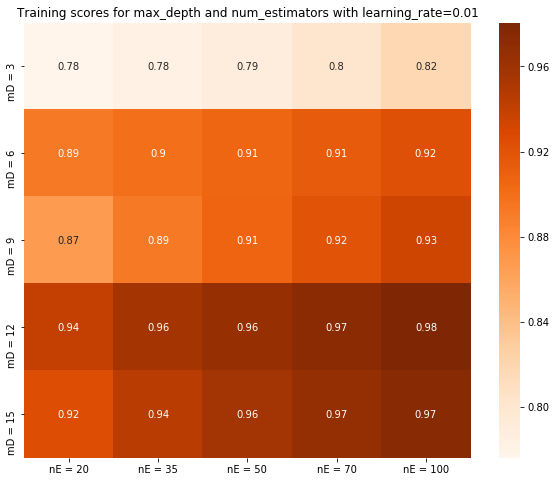

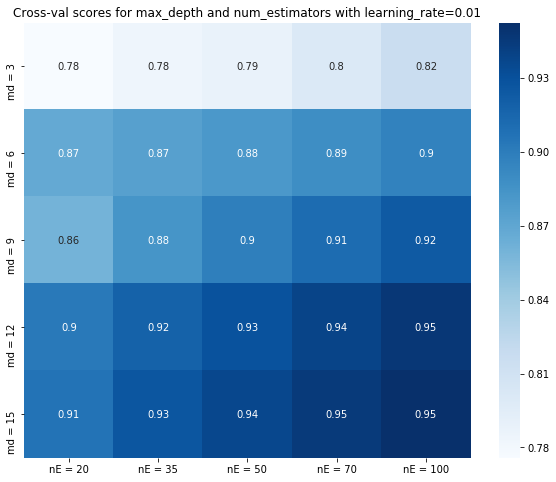

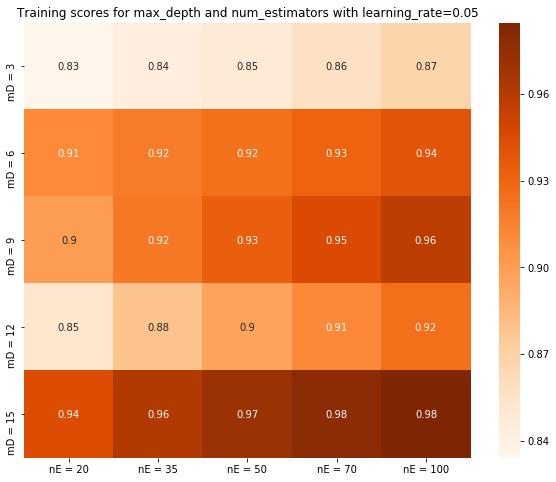

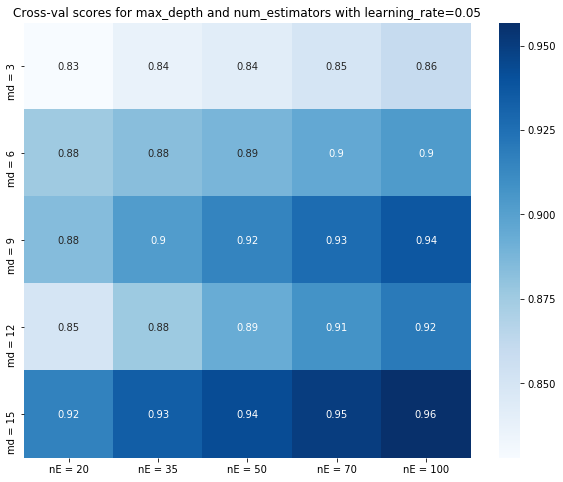

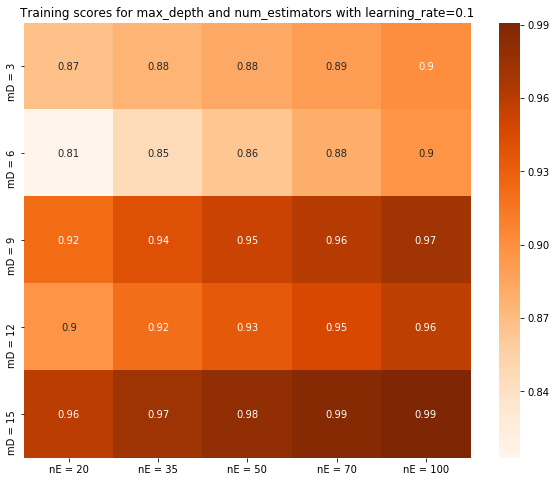

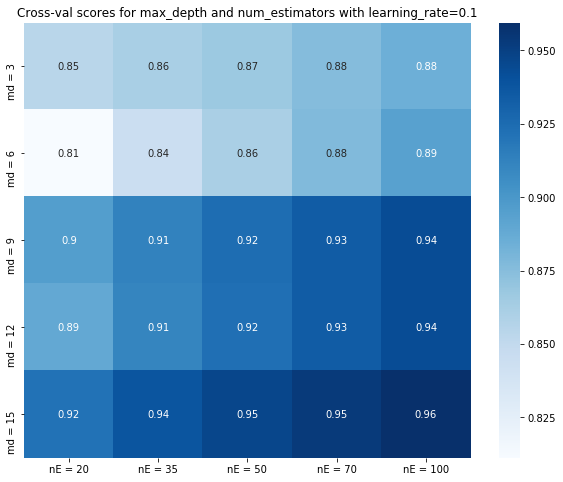

In [69]:
# Please write all the code with proper documentation
GBDT_Classifier(bow_train, rs_train)

Using max depth value for tree -  15
Using num estimators for tree -  300
Train accuracy for optimal GB Tree  97.72
Test accuracy for optimal GB Tree  90.69


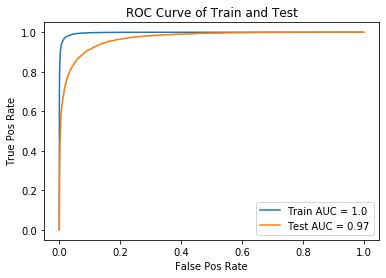

In [67]:
# Please write all the code with proper documentation

# Getting improved results by changing estimators from 100 to 300
maxDepth, learning_rate, n_estimators = 15,0.1,300
classifier, pred_train, pred_test, auc_score = GBDT_Classifier_Test(
            n_estimators, maxDepth, learning_rate, bow_train, 
            rs_train, bow_test, rs_test)

Training Confusion Matrix


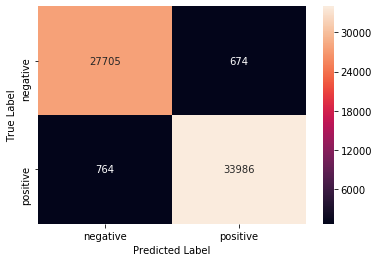




Test Confusion Matrix


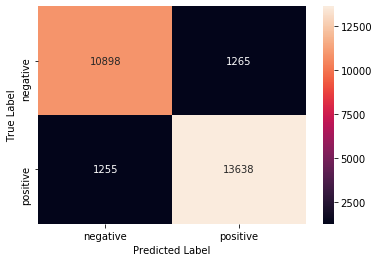

In [68]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["bow", "XGBoost", 
               "maxDepth: {0} \n num estimators: {1}\n\
learning_rate: {2}".format(
            maxDepth, n_estimators, learning_rate), auc_score])

In [69]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12163
           1       0.92      0.92      0.92     14893

   micro avg       0.91      0.91      0.91     27056
   macro avg       0.91      0.91      0.91     27056
weighted avg       0.91      0.91      0.91     27056



### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

Optimal Parameters :  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 6, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'class_weight': 'balanced'}


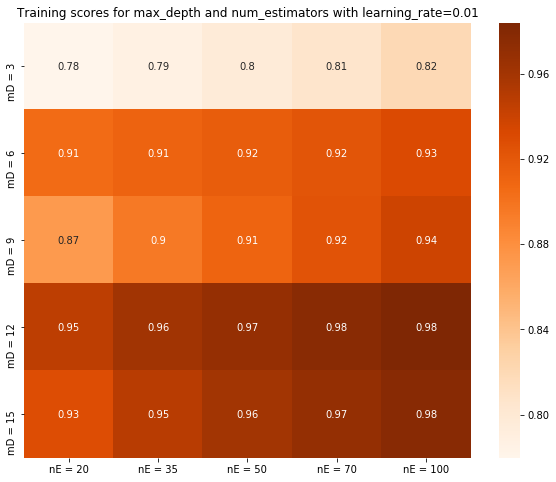

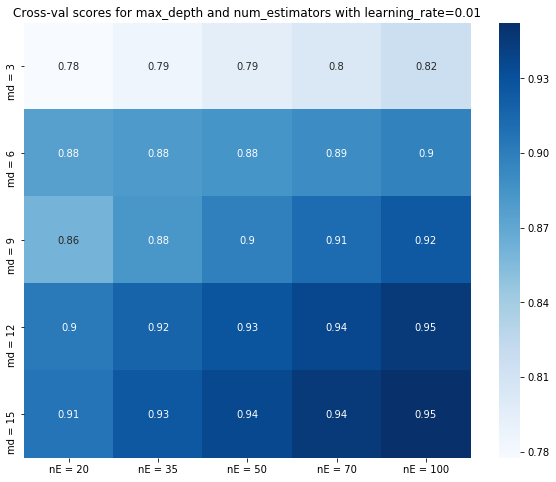

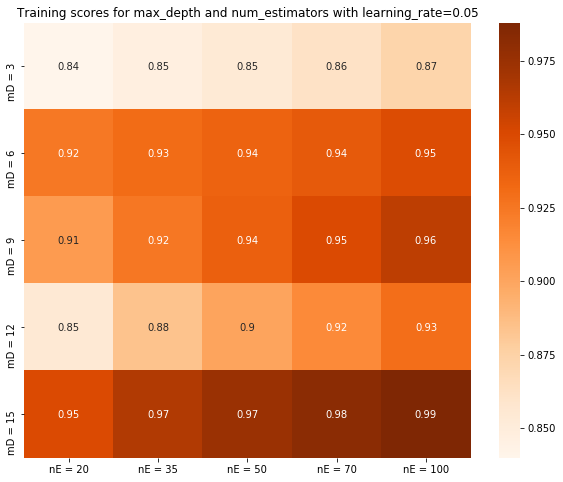

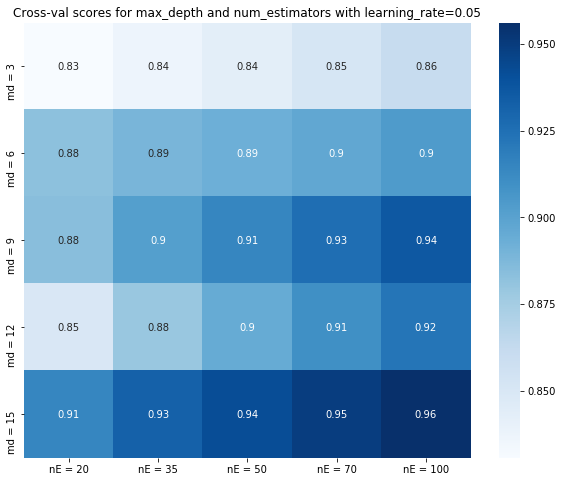

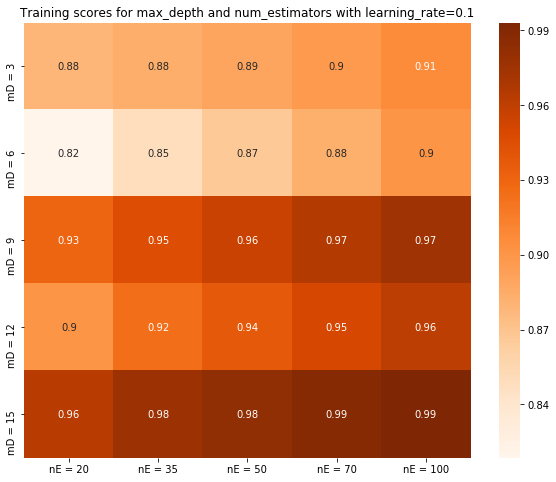

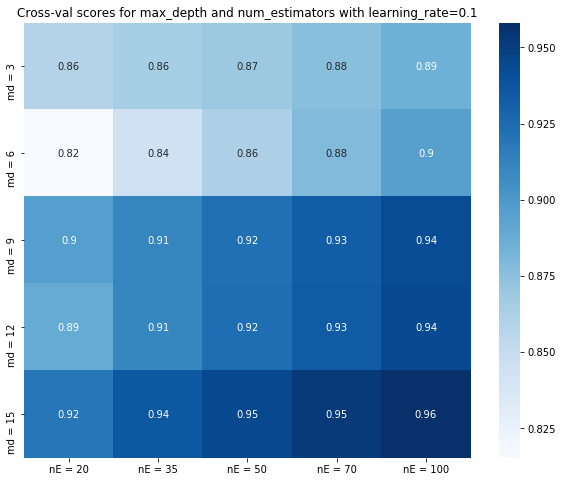

In [40]:
# Please write all the code with proper documentation
GBDT_Classifier(tfIdf_train, rs_train)

Using max depth value for tree -  15
Using num estimators for tree -  300
Train accuracy for optimal GB Tree  98.37
Test accuracy for optimal GB Tree  90.68


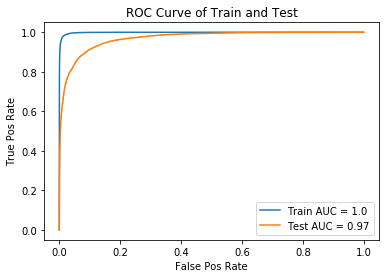

In [70]:
# Please write all the code with proper documentation

# Getting improved results by changing estimators from 100 to 300
maxDepth, learning_rate, n_estimators = 15,0.1,300
classifier, pred_train, pred_test, auc_score = GBDT_Classifier_Test(
            n_estimators, maxDepth, learning_rate, tfIdf_train, 
            rs_train, tfIdf_test, rs_test)

Training Confusion Matrix


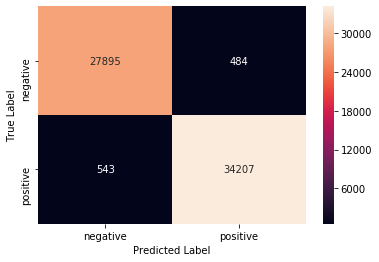




Test Confusion Matrix


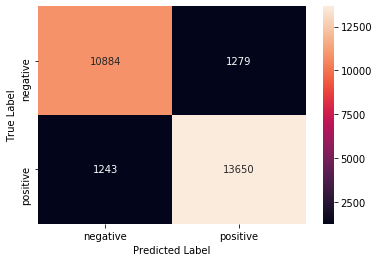

In [71]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["tf-Idf", "XGBoost", 
               "maxDepth: {0} \n num estimators: {1}\n\
learning_rate: {2}".format(
            maxDepth, n_estimators, learning_rate), auc_score])

In [72]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     12163
           1       0.91      0.92      0.92     14893

   micro avg       0.91      0.91      0.91     27056
   macro avg       0.91      0.91      0.91     27056
weighted avg       0.91      0.91      0.91     27056



### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

Optimal Parameters :  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 6, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'class_weight': 'balanced'}


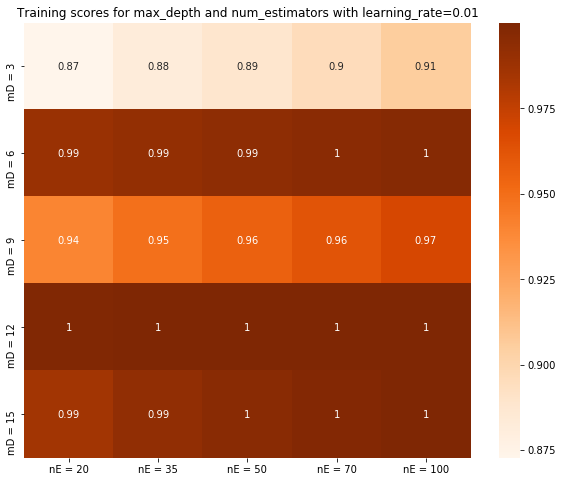

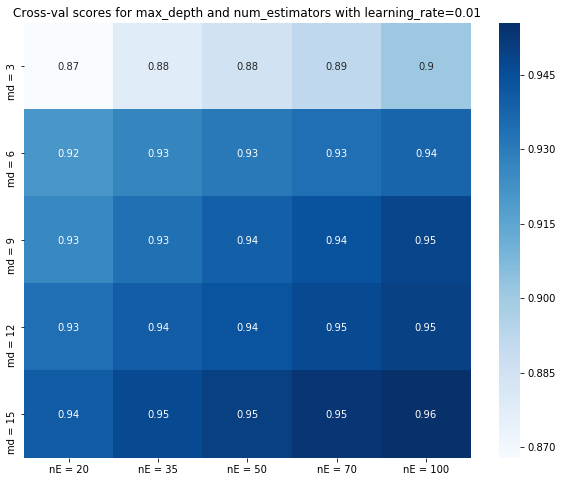

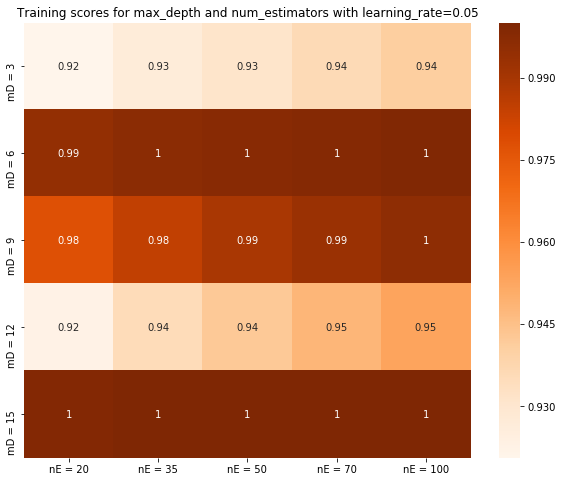

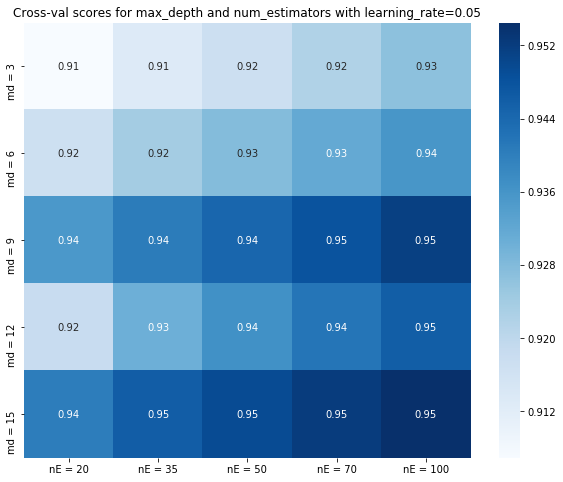

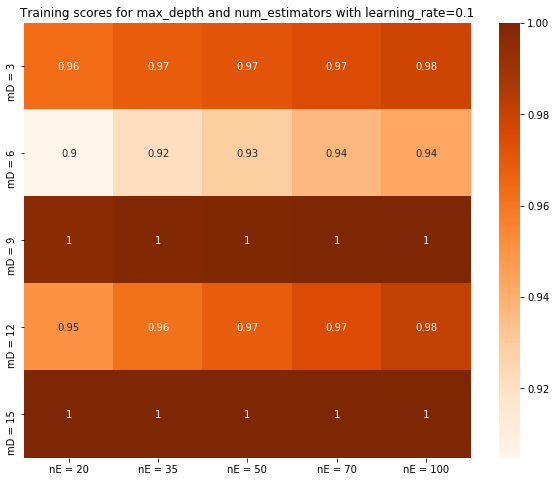

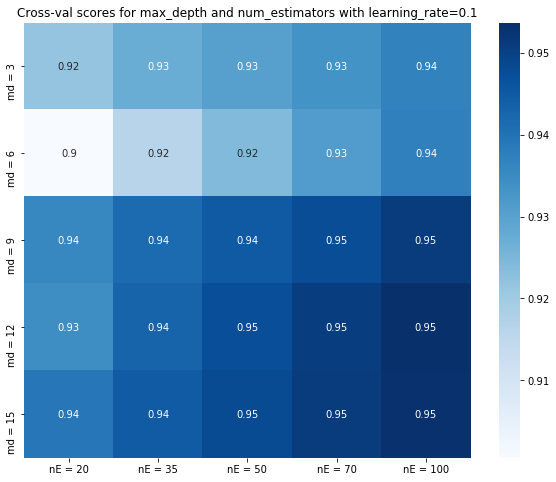

In [54]:
# Please write all the code with proper documentation
GBDT_Classifier(np.array(avgW2V_train), rs_train)

Using max depth value for tree -  9
Using num estimators for tree -  300
Train accuracy for optimal GB Tree  100.0
Test accuracy for optimal GB Tree  89.06


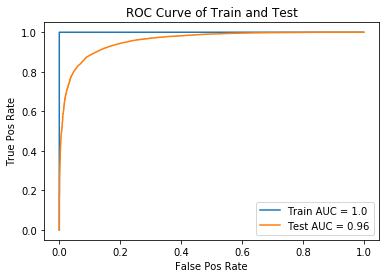

In [73]:
# Please write all the code with proper documentation

# Getting improved results by changing estimators from 100 to 300
maxDepth, learning_rate, n_estimators = 9,0.1,300
classifier, pred_train, pred_test, auc_score = GBDT_Classifier_Test(
            n_estimators, maxDepth, learning_rate, np.array(avgW2V_train), 
            rs_train, np.array(avgW2V_test), rs_test)

Training Confusion Matrix


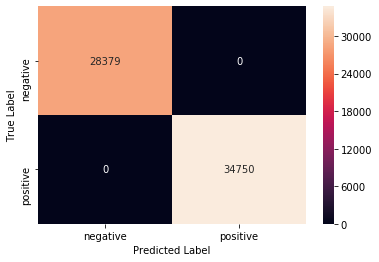




Test Confusion Matrix


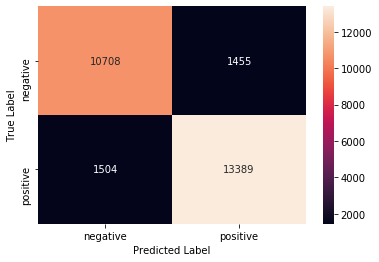

In [74]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Avg-W2V", "XGBoost", 
               "maxDepth: {0} \n num estimators: {1}\n\
learning_rate: {2}".format(
            maxDepth, n_estimators, learning_rate), auc_score])

In [75]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12163
           1       0.90      0.90      0.90     14893

   micro avg       0.89      0.89      0.89     27056
   macro avg       0.89      0.89      0.89     27056
weighted avg       0.89      0.89      0.89     27056



### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

Optimal Parameters :  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 6, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'class_weight': 'balanced'}


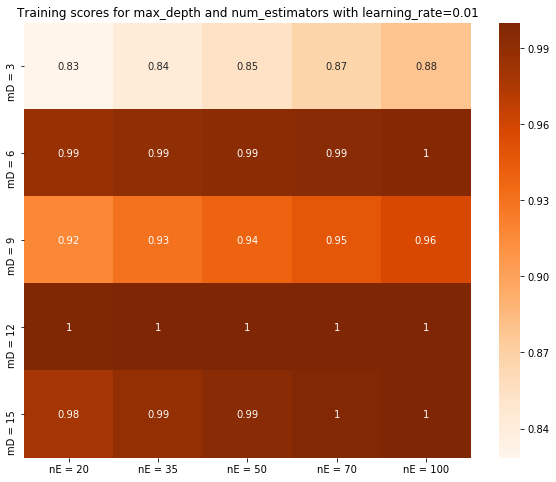

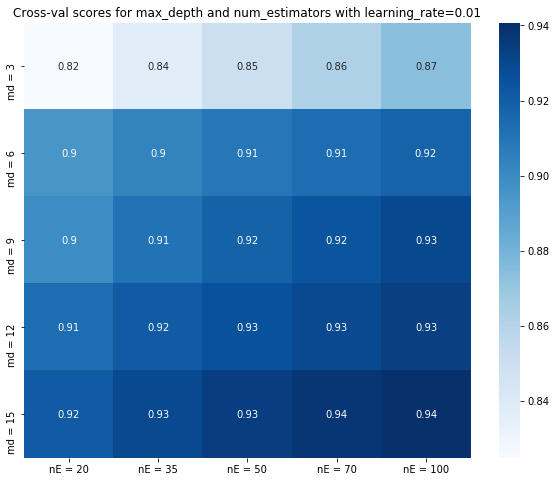

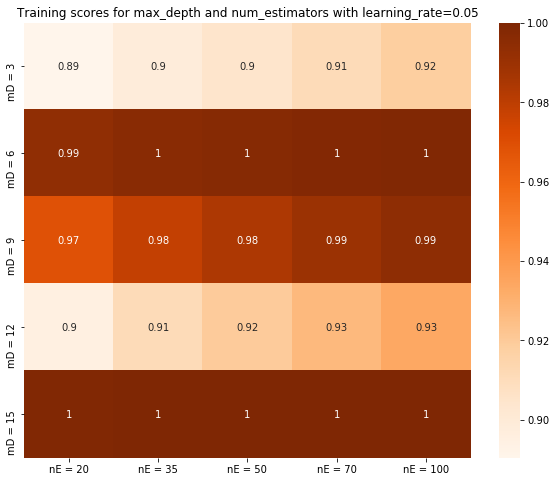

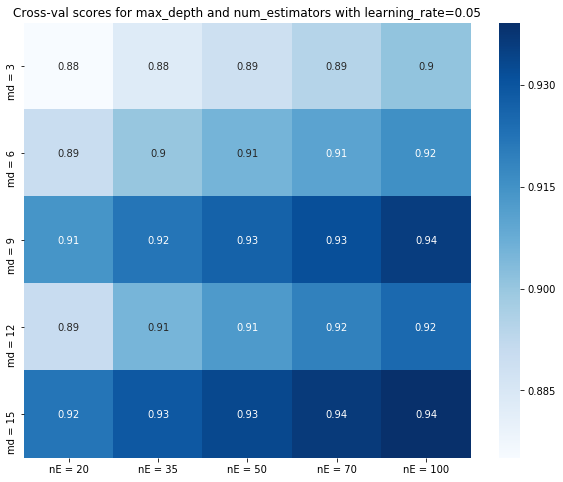

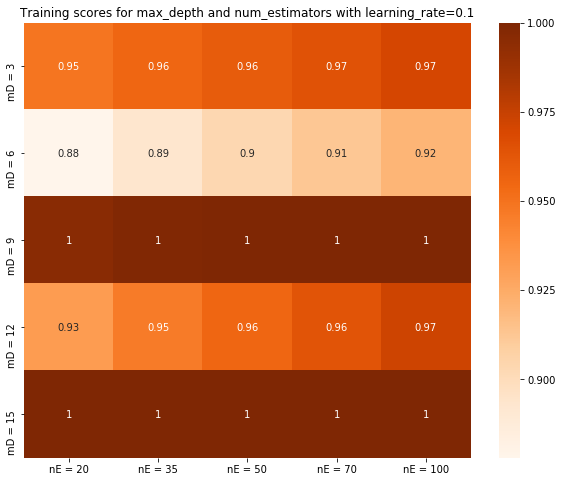

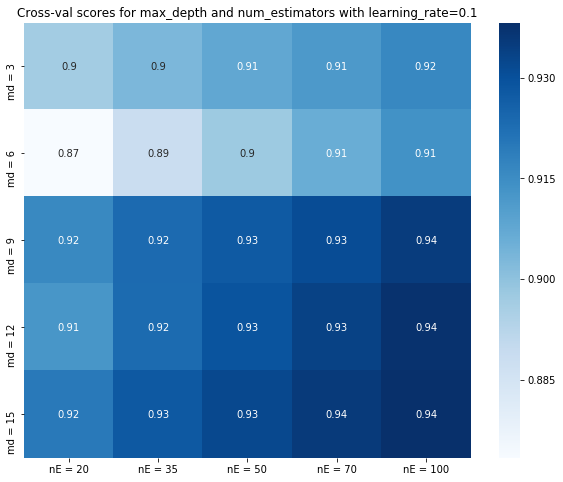

In [55]:
# Please write all the code with proper documentation
GBDT_Classifier(np.array(tfidf_avgW2V_train), rs_train)

Using max depth value for tree -  9
Using num estimators for tree -  300
Train accuracy for optimal GB Tree  100.0
Test accuracy for optimal GB Tree  87.35


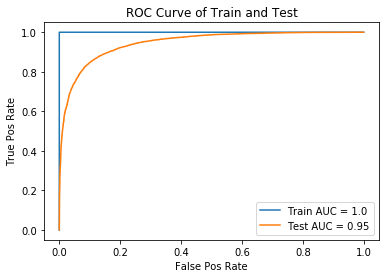

In [76]:
# Please write all the code with proper documentation

# Getting improved results by changing estimators from 100 to 300
maxDepth, learning_rate, n_estimators = 9,0.1,300
classifier, pred_train, pred_test, auc_score = GBDT_Classifier_Test(
            n_estimators, maxDepth, learning_rate, np.array(tfidf_avgW2V_train), 
            rs_train, np.array(tfidf_avgW2V_test), rs_test)

Training Confusion Matrix


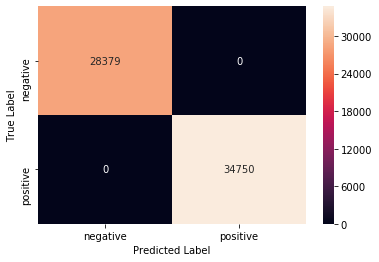




Test Confusion Matrix


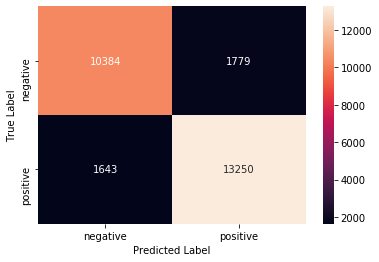

In [77]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf W2V", "XGBoost", 
               "maxDepth: {0} \n num estimators: {1}\n\
learning_rate: {2}".format(
            maxDepth, n_estimators, learning_rate), auc_score])

In [78]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86     12163
           1       0.88      0.89      0.89     14893

   micro avg       0.87      0.87      0.87     27056
   macro avg       0.87      0.87      0.87     27056
weighted avg       0.87      0.87      0.87     27056



# [6] Conclusions

In [81]:
# Please compare all your models using Prettytable library
print(table)

+----------------+---------------+------------------------------------+-----------+
|   Vectorizer   |     Model     |          Hyperparameters           | AUC Score |
+----------------+---------------+------------------------------------+-----------+
|      bow       | Random Forest | maxDepth: 125  num estimators: 500 |    0.95   |
|     tf-Idf     | Random Forest | maxDepth: 150  num estimators: 500 |    0.96   |
|    Avg W2V     | Random Forest | maxDepth: 30  num estimators: 500  |    0.92   |
| Tf-Idf Avg W2V | Random Forest |           maxDepth: 50             |    0.89   |
|                |               |         num estimators: 500        |           |
|                |               |        min_samples_leaf: 3         |           |
|      bow       |    XGBoost    |           maxDepth: 15             |    0.97   |
|                |               |         num estimators: 300        |           |
|                |               |         learning_rate: 0.1         |     

     - We can clearly see that the random forests trees are clearly able to achieve 
       a good level of accuracy. Especially the classifier using bow and tf-Idf are 
       performing much better compared to the ones using average and tf-Idf weighted 
       average
     - However, their level of accuracy is below the previosly worked on, LR or SVM
     - The similar trend can be seen for xgBoost, where the classifier using bow and
       tf-Idf vectors peform well compared to ones using average and tf-Idf weighted
       word2Vec. The later ones not only have slightly lower accuracy but also have
       slight amount of variance compared to the former
     - For both the RF and XGBoost, tuning 3 instead of 2 hyperparams makes the models
       stable